In [4]:
%run ../_preamble.ipynb
from _work.src.data import simple_dataloader, create_dataloader
from _work.src.models import AutoEncoder
from _work.src.modules.eval import eval_model
from _work.src.modules.train import train_model
from _work.src.modules.replay import get_attractors, iterate
from _work.src.modules.plot import (
    plot_metrics,
    plot_parameters,
    plot_tensor,
    plot_grid,
    plot_SVD,
)
from _work.src.modules.utils import get_closest_item
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

<AxesSubplot:>

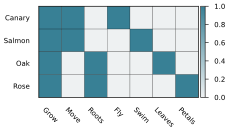

In [15]:
plot_tensor(simple_dataloader.dataset.df)

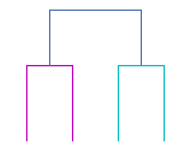

In [14]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(simple_dataloader.dataset.df)

def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
    
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    return hierarchy.dendrogram(linkage_matrix, get_leaves=True, **kwargs)

res = plot_dendrogram(model);
leaves = res['leaves']
plt.xticks([]);
plt.yticks([]);
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

In [4]:
data = [
    [0, 0.4],
    [0.2, 0.2],
    [0.6, 0.6],
    [0.9, 0.2],
    [0.3, 0.7],
    [0.1, 0.5],
    # [0.5, 0.1],
    # [0.1, 0],
]

dataloader = create_dataloader(pd.DataFrame(
    data=data,
    columns=["number1", "number2"],
    index=["one", "two", "three", "four", "five", "six"],
), batch_size=2)

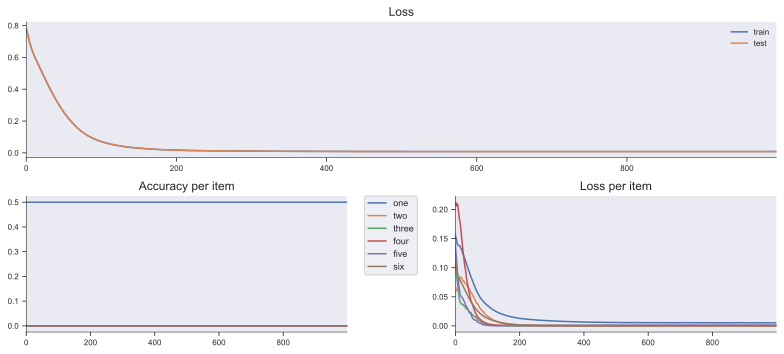

In [5]:
metrics = train_model(
    model := AutoEncoder(
        sizes=[dataloader.dataset.NUM_ATTRIBUTES, 2],
        batch_norm=False,
        dropout=0,
    ),
    optimizer := torch.optim.AdamW(model.parameters(), lr=1e-2),
    loss_fn := torch.nn.MSELoss(reduction="sum"),
    dataloader,
    epochs=1000,
)

plot_metrics(metrics);

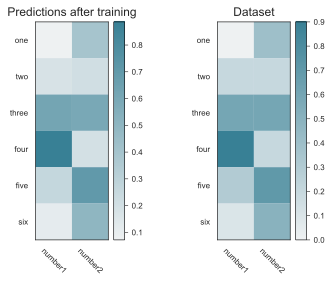

In [6]:
eval_model(model, dataloader);

In [150]:
outs = []
with torch.no_grad():
    for item in dataloader.dataset:
        print(item)
        out = model.encoder(item['y'])
        outs.append(out)

        res = model.decoder(out)
        print(get_closest_item(dataloader.dataset.df, res, metric='euclidean'))
torch.vstack(tuple(outs))

{'x': tensor([1., 0., 0., 0., 0., 0.]), 'y': tensor([0.0000, 0.4000])}
('one', 0.07260188000407697)
{'x': tensor([0., 1., 0., 0., 0., 0.]), 'y': tensor([0.2000, 0.2000])}
('two', 0.022510196973430974)
{'x': tensor([0., 0., 1., 0., 0., 0.]), 'y': tensor([0.6000, 0.6000])}
('three', 0.03053245066872045)
{'x': tensor([0., 0., 0., 1., 0., 0.]), 'y': tensor([0.9000, 0.2000])}
('four', 0.010213759224712921)
{'x': tensor([0., 0., 0., 0., 1., 0.]), 'y': tensor([0.3000, 0.7000])}
('five', 0.03385471185845432)
{'x': tensor([0., 0., 0., 0., 0., 1.]), 'y': tensor([0.1000, 0.5000])}
('six', 0.015245962072379307)


tensor([[0.0061, 1.0933],
        [0.0199, 0.5022],
        [1.3381, 1.1095],
        [1.1973, 0.0000],
        [0.9948, 1.5488],
        [0.3357, 1.2451]])

In [14]:
plot_grid(model, dataloader);

In [277]:
steps = 100
activ_attr, counts = get_attractors(
    model,
    runs=20,
    steps=steps,
    burn_in_time=5,
    states_or_activations="activations",
    min_occurrence=0,
    round=False,
)
# activ_attr, counts

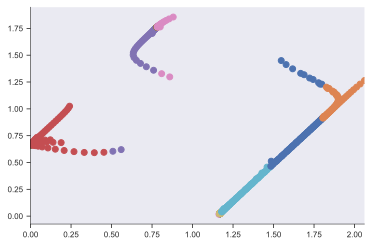

In [278]:
for i, j in enumerate([*range(0, len(activ_attr) - 1, steps - 5)]):
    plt.scatter(activ_attr[j:j+steps-5, 0], activ_attr[j:j+steps-5, 1], label=i)
# plt.scatter(activ_attr[:, 0], activ_attr[:, 1]);
# plt.xlim([-0.5, 2]);
# plt.ylim([-0.5, 2]);

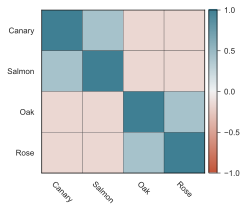

In [45]:
plot_tensor(dataloader.dataset.df.transpose().corr());
plt.savefig("../plots/correlation_matrix")